## Building Chatbot with multiple tools using langgraph

## AIM 

Create a chatbot with tool capabilities from arxiv, wikipedia, search and some functions

In [6]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper


In [7]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

In [8]:
print(arxiv.name)

arxiv


In [9]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [10]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper = api_wrapper_wiki)
wiki.name

'wikipedia'

In [11]:
wiki.invoke('what is attention is all you need?')

'Page: Attention Is All You Need\nSummary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, as the transformer approach has become the main architecture of a wide variety of AI, such as large languag'

In [12]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [13]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\princ\AppData\Local\Temp\ipykernel_8680\735679136.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [14]:
tavily.invoke("Provide me the latest news of Artificial Intelligence")

[{'title': 'Artificial intelligence - NBC News',
  'url': 'https://www.nbcnews.com/artificial-intelligence',
  'content': "Profile\n\nSections\n\nLocal\n\ntv\n\nFeatured\n\nMore From NBC\n\nFollow NBC News\n\nnews Alerts\n\nThere are no new alerts at this time\n\n# ARTIFICIAL INTELLIGENCE\n\nThe latest news and top stories on artificial intelligence, including ChatGPT, AI Chatbot and Bard.\n\nImage: Jerome Powell and Sam Altman Speak At Federal Reserve's Regulatory Capital Framework Conference\n\n## OpenAI announces new 'study mode' product for students\n\nHuman hands pointing at vintage computers [...] ### VERB A.I. pays some users $50 a month to access data\n\n## NBC News NOW\n\n## 01:21\n\n### Trump announces AI action plan during summit\n\n## 03:07\n\n### Roblox rolls out new AI-powered safety measures to protect teens\n\n## NBC News NOW\n\n## 03:13\n\n### Couple uses artificial intelligence to fight insurance denial\n\n## Nightly News\n\n## 09:51\n\n### Trump ‘touting’ business pr

In [15]:
##n combine all the tools

tools = [arxiv, wiki, tavily]

In [16]:
## Initalize llm model

from langchain_groq import ChatGroq
llm = ChatGroq(model = "qwen/qwen3-32b")

llm_with_tools = llm.bind_tools(tools)

In [17]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. Let me think about how to approach this.\n\nFirst, I need to figure out which tool to use. The available tools are arxiv, wikipedia, and tavily_search_results_json. \n\nArxiv is good for academic papers, but the user is asking for news, not research papers. Wikipedia might have some information, but it\'s more of a general knowledge encyclopedia and might not have the latest news. Tavily_search_results_json sounds like a search tool that can fetch recent news articles. \n\nSo, I should use the tavily_search_results_json function with the query "recent AI News". That should retrieve the latest news articles on AI. I\'ll make sure the query is clear and specific enough. Let me check the parameters again. The function requires a "query" parameter, which I\'ll set to "recent AI News". \n\nI think that\'s the right choice. Let me structure the tool call accordingly.\n', 'tool_calls': 

In [18]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'v7rft0ayr',
  'type': 'tool_call'}]

In [19]:
## Entire chatbot with langgraph
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages, AnyMessage

In [20]:
class LLMState(TypedDict):
    messages : Annotated[list[AnyMessage],add_messages]

In [21]:
def tool_calling_llm(state: LLMState):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


In [22]:
graph = StateGraph(LLMState)
graph.add_node("tool_calling_llm",tool_calling_llm)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "tool_calling_llm")
graph.add_conditional_edges("tool_calling_llm",tools_condition)
graph.add_edge("tools",END)

workflow = graph.compile()

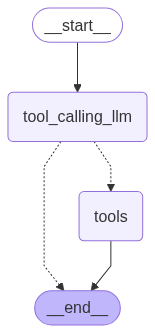

In [23]:
workflow

In [28]:
initial_state = {"messages": [HumanMessage(content="Recently prime minister visited to which country?")]}
messages = workflow.invoke(initial_state)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Recently prime minister visited to which country?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (bmq8t9ex7)
 Call ID: bmq8t9ex7
  Args:
    query: recent prime minister visit country
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "PM's Visits | Prime Minister of India", "url": "https://www.pmindia.gov.in/en/pm-visits/", "content": "### PM’s visit to Mauritius(Mar 11, 2025 - Mar 12, 2025 )\n\n### PM’s visit to France & USA(Feb 10, 2025 - Feb 14, 2025 )\n\n### PM’s visit to Kuwait(Dec 21, 2024 - Dec 22, 2024 )\n\n### PM’s visit to Nigeria, Brazil & Guyana(Nov 16, 2024 - Nov 22, 2024 )\n\n### PM’s visit to Russia(Oct 22, 2024 - Oct 23, 2024 )\n\n## OUR Government\n\nThe President of India\n\n##### The President of India\n\nRajya Sabha\n\n##### Rajya Sabha\